In [1]:
import tensorflow as tf
from keras import backend as K

D:\Users\Yue\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
%matplotlib inline

In [3]:
sess = tf.InteractiveSession()
K.set_session(sess)

In [4]:
import sys
sys.path.append('..')
from optimizer import NormalizedOptimizer

In [5]:
from keras.optimizers import SGD

# Code from [kmkolasinski/deep-learning-notes](https://github.com/kmkolasinski/deep-learning-notes/blob/master/max-normed-optimizer/notebooks/Solving_quadratic_equation.ipynb)

# Generate dataset

In [6]:
import sklearn.datasets as sk_datasets
# dimensionality of the problem
ndims = 100
# Q [ndims, ndims] symetric positive define matrix
Q = sk_datasets.make_spd_matrix(ndims).astype(np.float32)
# b random vector of shape [ndims, 1]
b = np.random.randn(ndims, 1).astype(np.float32)
# w0 initial state of the unknown variable, vector of shape [ndims, 1]
w0 = np.random.randn(ndims, 1).astype(np.float32)

# Loss function

In [8]:
weights = tf.get_variable(
        name='w', 
        dtype=tf.float32, 
        initializer=w0)

In [9]:
def L(w0, Q, b, weights):
    """Define loss function"""
    # 0.5 x^T Q x + b^T x
    loss = 0.5 * tf.matmul(tf.transpose(weights), tf.matmul(Q, weights)) \
         - tf.matmul(tf.transpose(b), weights)
    
    return tf.reshape(loss, (1,))

In [10]:
lr = 0.1
history = []
max_iter = 1500

sgd = SGD(lr=lr, momentum=0.9, nesterov=True)
optimizer = NormalizedOptimizer(sgd, normalization='l2')

In [11]:
loss = L(w0, Q, b, weights)
train_op = optimizer.get_updates(loss, [weights])

In [12]:
sess.run(tf.global_variables_initializer())
for i in range(max_iter):
    loss_value, _ = sess.run([loss, train_op])
    history.append(loss_value)
    
    if i % 99 == 0:
        print("Iteration %d: Loss = %0.4f" % (i + 1, loss_value))
history = np.array(history)

Iteration 1: Loss = 94.4129
Iteration 100: Loss = -186.5157
Iteration 199: Loss = -248.3905
Iteration 298: Loss = -288.8245
Iteration 397: Loss = -318.6800
Iteration 496: Loss = -341.8467
Iteration 595: Loss = -360.2666
Iteration 694: Loss = -375.1227
Iteration 793: Loss = -387.2202
Iteration 892: Loss = -397.1454
Iteration 991: Loss = -405.3398
Iteration 1090: Loss = -412.1411
Iteration 1189: Loss = -417.8142
Iteration 1288: Loss = -422.5672
Iteration 1387: Loss = -426.5627
Iteration 1486: Loss = -429.9427


(0, 1500)

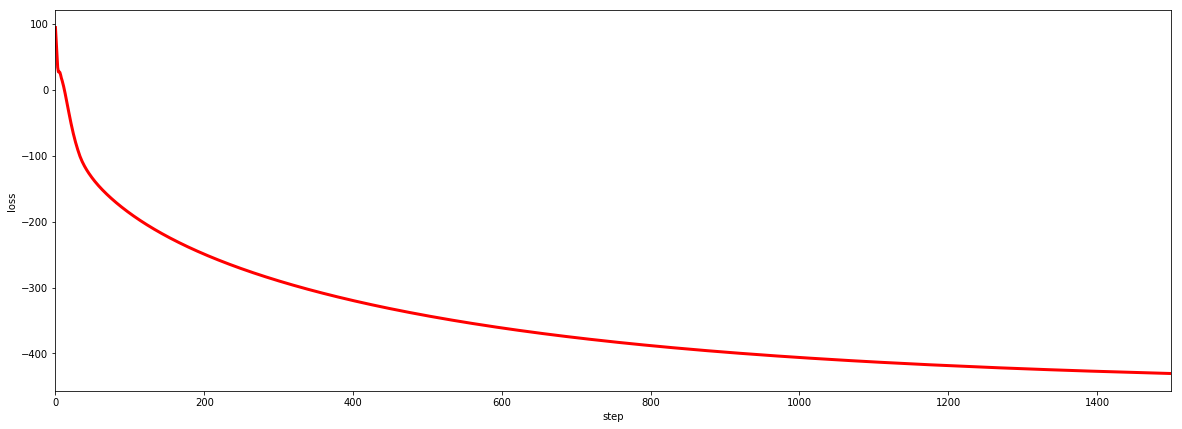

In [13]:
plt.figure(figsize=(20, 7))
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(history[:, 0], 'r-', lw=3)
plt.xlim([0, max_iter])

# Comparison with other optimizers and different learning rates

In [14]:
def fit(optimizer, scope):
    """Solve quadratic problem with given optimizer.
    Returns loss history.
    """
    history = []
    max_iter = 1000
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        weights = tf.get_variable(
                            name='w-%s' % (scope), 
                            dtype=tf.float32, 
                            initializer=w0)
        loss = L(w0, Q, b, weights)
        update_op = optimizer.get_updates(loss, [weights])
        sess.run(tf.global_variables_initializer())    
        
    for i in range(max_iter):
        loss_value, _= sess.run([loss, update_op])     
        history.append([i, loss_value])   
    history = np.array(history)
    return history


In [15]:
from keras.optimizers import Adam, RMSprop
from collections import OrderedDict

In [55]:
comparisons = OrderedDict()
min_value, max_value = 0, 0
for lr_np in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1]:
    print('lr=%0.3f' % (lr_np))
    
    sgd = NormalizedOptimizer(SGD(lr_np, momentum=0.9, nesterov=True), normalization='std')
    rmsprop = RMSprop(lr=lr_np, rho=0.9)
    adam = Adam(lr=lr_np)
    
    hist_nsgd = fit(sgd, 'NSGD-%0.3f' % (lr_np))
    hist_adam = fit(adam, 'Adam-%0.3f' % (lr_np))
    hist_momentum = fit(rmsprop, 'Momentum-%0.3f' % (lr_np))
    
    comparisons[lr_np] = OrderedDict()
    comparisons[lr_np]['NSGD'] = hist_nsgd
    comparisons[lr_np]['Adam'] = hist_adam
    comparisons[lr_np]['Momentum'] = hist_momentum
    
    # keep min max for plotting reasons
    min_value = min(np.min(hist_nsgd), min_value)
    max_value = max(np.max(hist_nsgd), max_value)

lr=0.001
lr=0.005
lr=0.010
lr=0.030
lr=0.050
lr=0.100


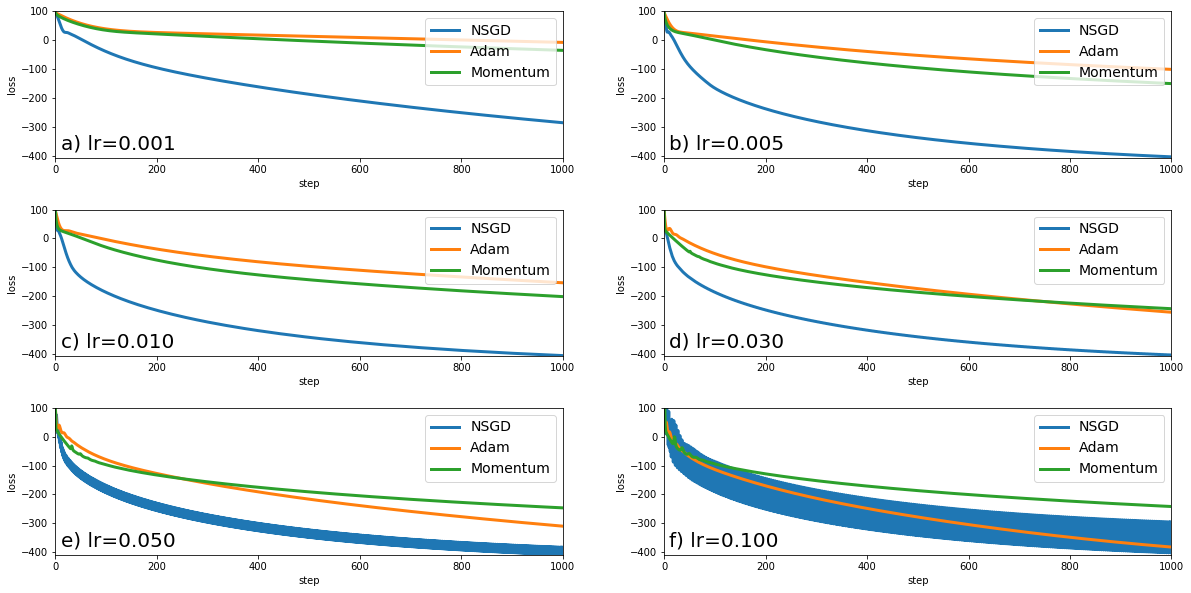

In [58]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.35)

for k, (lr, hists) in enumerate(comparisons.items()):    
    plt.subplot(len( comparisons.items())//2, 2, k + 1)
    plt.text(10, min_value+30, '%s) lr=%0.3f' % (chr(ord("a") + k), lr), size=20)
    for opt, hist in hists.items():        
        plt.plot(hist[:, 0], hist[:, 1], label=opt, lw=3)
    plt.legend(loc='upper right', fontsize=14)
    plt.ylim([min_value, 100])
    plt.xlim([0, 1000])
    plt.ylabel('loss')
    plt.xlabel('step')


# Dependency on initial choice of learning rate

In [63]:
from matplotlib import cm

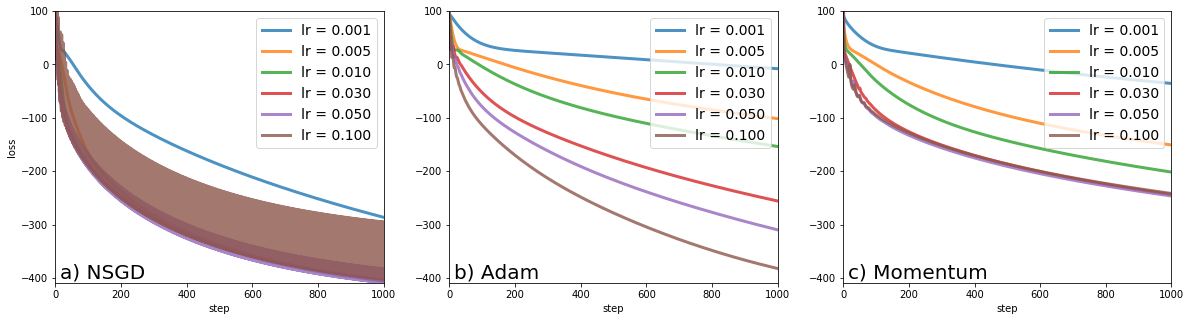

In [70]:
plt.figure(figsize=(20, 5))
for s, opt in enumerate(['NSGD', 'Adam', 'Momentum']):
    plt.subplot(1, 3, s + 1)        
    plt.text(15, min_value+0.02*abs(min_value), '%s) %s' % (chr(ord("a") + s), opt), size=20)
    for k, (lr, hists) in enumerate(comparisons.items()):  
        label = 'lr = %0.3f' % lr if hists[opt][-100:, 1].max() < 0 else 'lr = %0.3f (not converged)' % (l4)
        if hists[opt][-100:, 1].max() < 0:
            plt.plot(hists[opt][:, 0], hists[opt][:, 1], label=label, lw=3, alpha=0.8)
        else:
            plt.plot(hists[opt][:, 0], hists[opt][:, 1]*0, label=label, alpha=0.0)
    plt.legend(loc='upper right', fontsize=14)
    plt.ylim([min_value, 100])    
    plt.xlim([0, 1000])
    plt.xlabel('step')
    if s == 0: plt.ylabel('loss')


# Normalizing other optimizers (ADAM)

In [16]:
comparisons = OrderedDict()
min_value, max_value = 0, 0
for lr_np in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1]:
    print('lr=%0.3f' % (lr_np))
    
    normalized_adam = NormalizedOptimizer(Adam(lr_np), normalization='std')
    rmsprop = RMSprop(lr=lr_np, rho=0.9)
    adam = Adam(lr=lr_np)
    
    hist_nsgd = fit(sgd, 'NADAM-%0.3f' % (lr_np))
    hist_adam = fit(adam, 'Adam-%0.3f' % (lr_np))
    hist_momentum = fit(rmsprop, 'Momentum-%0.3f' % (lr_np))
    
    comparisons[lr_np] = OrderedDict()
    comparisons[lr_np]['NADAM'] = hist_nsgd
    comparisons[lr_np]['Adam'] = hist_adam
    comparisons[lr_np]['Momentum'] = hist_momentum
    
    # keep min max for plotting reasons
    min_value = min(np.min(hist_nsgd), min_value)
    max_value = max(np.max(hist_nsgd), max_value)

lr=0.001
lr=0.005
lr=0.010
lr=0.030
lr=0.050
lr=0.100


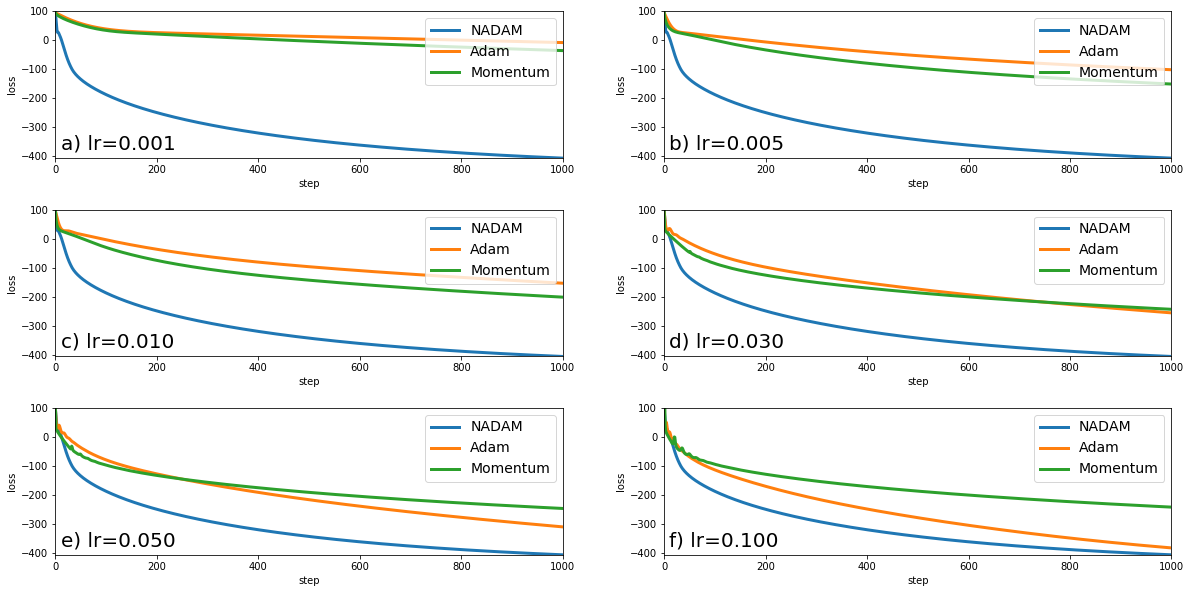

In [17]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.35)

for k, (lr, hists) in enumerate(comparisons.items()):    
    plt.subplot(len( comparisons.items())//2, 2, k + 1)
    plt.text(10, min_value+30, '%s) lr=%0.3f' % (chr(ord("a") + k), lr), size=20)
    for opt, hist in hists.items():        
        plt.plot(hist[:, 0], hist[:, 1], label=opt, lw=3)
    plt.legend(loc='upper right', fontsize=14)
    plt.ylim([min_value, 100])
    plt.xlim([0, 1000])
    plt.ylabel('loss')
    plt.xlabel('step')

# Benefits of NormalizedOptimizer wrapper class

- Since this is a wrapper class over all optimizers, no matter which optimizer is chosen as the base Optimizer, we can perform any kind of normalization. 
- It is also serializable with `model.save()` and can be loaded with `load_model()` while supplying the `custom_objects` parameter.
- It will monkey patch only the optimizer object that it wraps, and not the original class itself, so you can use multiple optimizers and wrap only those you want.
- **Normalized Adam is very useful for fast convergence, even with high learning rates !**

# Dependency on initial choice of learning rate

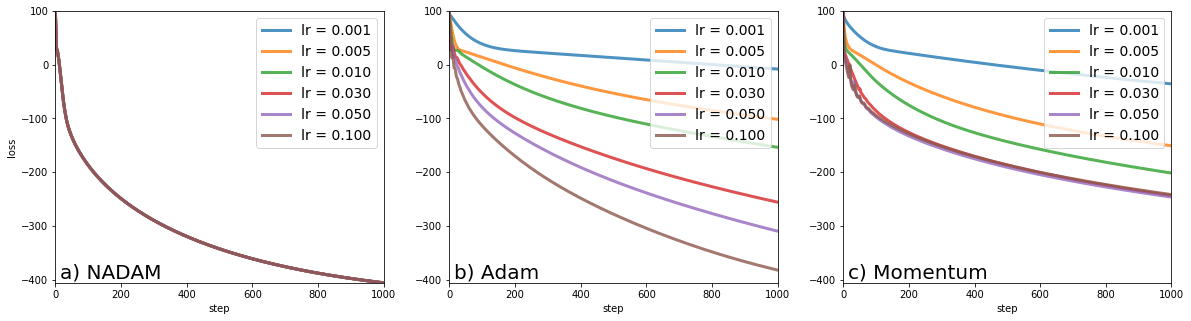

In [18]:
plt.figure(figsize=(20, 5))
for s, opt in enumerate(['NADAM', 'Adam', 'Momentum']):
    plt.subplot(1, 3, s + 1)        
    plt.text(15, min_value+0.02*abs(min_value), '%s) %s' % (chr(ord("a") + s), opt), size=20)
    for k, (lr, hists) in enumerate(comparisons.items()):  
        label = 'lr = %0.3f' % lr if hists[opt][-100:, 1].max() < 0 else 'lr = %0.3f (not converged)' % (l4)
        if hists[opt][-100:, 1].max() < 0:
            plt.plot(hists[opt][:, 0], hists[opt][:, 1], label=label, lw=3, alpha=0.8)
        else:
            plt.plot(hists[opt][:, 0], hists[opt][:, 1]*0, label=label, alpha=0.0)
    plt.legend(loc='upper right', fontsize=14)
    plt.ylim([min_value, 100])    
    plt.xlim([0, 1000])
    plt.xlabel('step')
    if s == 0: plt.ylabel('loss')